# Tune GPT2 to generate negative student feedbacks
> Optimise GPT2 to produce negative student feedbacks using a PhoBERT sentiment classifier as a reward function.

## Setup experiment

### Import dependencies

In [1]:
import torch
from tqdm import tqdm
import pandas as pd

tqdm.pandas()

from transformers import pipeline, AutoTokenizer
from datasets import load_dataset, concatenate_datasets

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

### Configuration

In [3]:
config = PPOConfig(
    model_name="binhphap5/gpt2-small-vietnamese-students-feedback",
    learning_rate=5e-5,
    log_with="wandb",
    # batch_size=128,
    # mini_batch_size=128,
    # gradient_accumulation_steps=2,
    init_kl_coef=0.4
)

sent_kwargs = {"top_k": None, "function_to_apply": "none", "batch_size": 16}

c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\trl\trainer\ppo_config.py:207: FutureWarning: `PPOConfig` is deprecated and will be removed in the future. Please use `PPOv2Config` with `PPOv2Trainer` instead.
  warnings.warn(


In [3]:
import wandb

wandb.init()

wandb: Currently logged in as: tridungluong123 (tridungluong123-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Load data and models

In [4]:
def build_dataset(
    config,
    dataset_name="uitnlp/vietnamese_students_feedback",
    input_min_text_length=2,
    input_max_text_length=8,
):
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    # tokenizer.pad_token = tokenizer.eos_token
    ds = load_dataset(dataset_name)
    ds = concatenate_datasets([ds["train"], ds["test"], ds["validation"]])
    ds = ds.rename_columns({"sentence": "feedback"})
    ds = ds.filter(lambda x: len(x["feedback"]) > 50, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        # this is query tensors
        sample["input_ids"] = tokenizer.encode(sample["feedback"])[: input_size()]
        # and this is query in form of a text
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

In [5]:
dataset = build_dataset(config)

def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

In [6]:
dataset

Dataset({
    features: ['feedback', 'sentiment', 'topic', 'input_ids', 'query'],
    num_rows: 7293
})

### Load pre-trained GPT2 language models

load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [ ]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
tokenizer = AutoTokenizer.from_pretrained(config.model_name)

### Initialize PPOTrainer

In [8]:
ppo_trainer = PPOTrainer(
    config, model, ref_model, tokenizer, dataset=dataset, data_collator=collator
)

c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\trl\trainer\ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(


### Load PhoBERT classifier

In [9]:
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu" 
sentiment_pipe = pipeline(
    "sentiment-analysis", model="binhphap5/phobert-vn-student-feedback-sentiment", device=device
)

Device set to use cuda:0


In [10]:
text = "môn này khó quá"
sentiment_pipe(text, **sent_kwargs)

[{'label': 'negative', 'score': 4.226722240447998},
 {'label': 'positive', 'score': -1.8237228393554688},
 {'label': 'neutral', 'score': -2.1703133583068848}]

In [11]:
text = "Thầy giảng bài thật hay !"
sentiment_pipe(text, **sent_kwargs)

[{'label': 'positive', 'score': 4.320021152496338},
 {'label': 'negative', 'score': -2.2614595890045166},
 {'label': 'neutral', 'score': -2.3723623752593994}]

In [12]:
gen_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}

### Training

In [13]:
output_min_length = 20
output_max_length = 40
output_length_sampler = LengthSampler(output_min_length, output_max_length)


generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}

epochs=5
for epoch in tqdm(range(epochs), "epoch: "):
    for batch in tqdm(ppo_trainer.dataloader):
        query_tensors = batch["input_ids"]

        # Get feedback from gpt2
        generation_kwargs["max_new_tokens"] = output_length_sampler()
        feedback_tensors = ppo_trainer.generate(query_tensors, **generation_kwargs, return_prompt=False)
        torch.cuda.empty_cache()
        batch["response"] = [tokenizer.decode(r.squeeze()) for r in feedback_tensors]

        # Compute sentiment score (negative)
        texts = [q + r for q, r in zip(batch["query"], batch["response"])]
        pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
        positive_scores = [
            item["score"]
            for output in pipe_outputs
            for item in output
            if item["label"] == "negative"
        ]
        rewards = [torch.tensor(score) for score in positive_scores]

        # Run PPO step
        stats = ppo_trainer.step(query_tensors, feedback_tensors, rewards)
        ppo_trainer.log_stats(stats, batch, rewards)

  0%|          | 0/56 [00:00<?, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.

 14%|█▍        | 8/56 [02:17<14:23, 17.99s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

epoch: 100%|██████████| 5/5 [1:06:34<00:00, 798.87s/it]


### Training progress
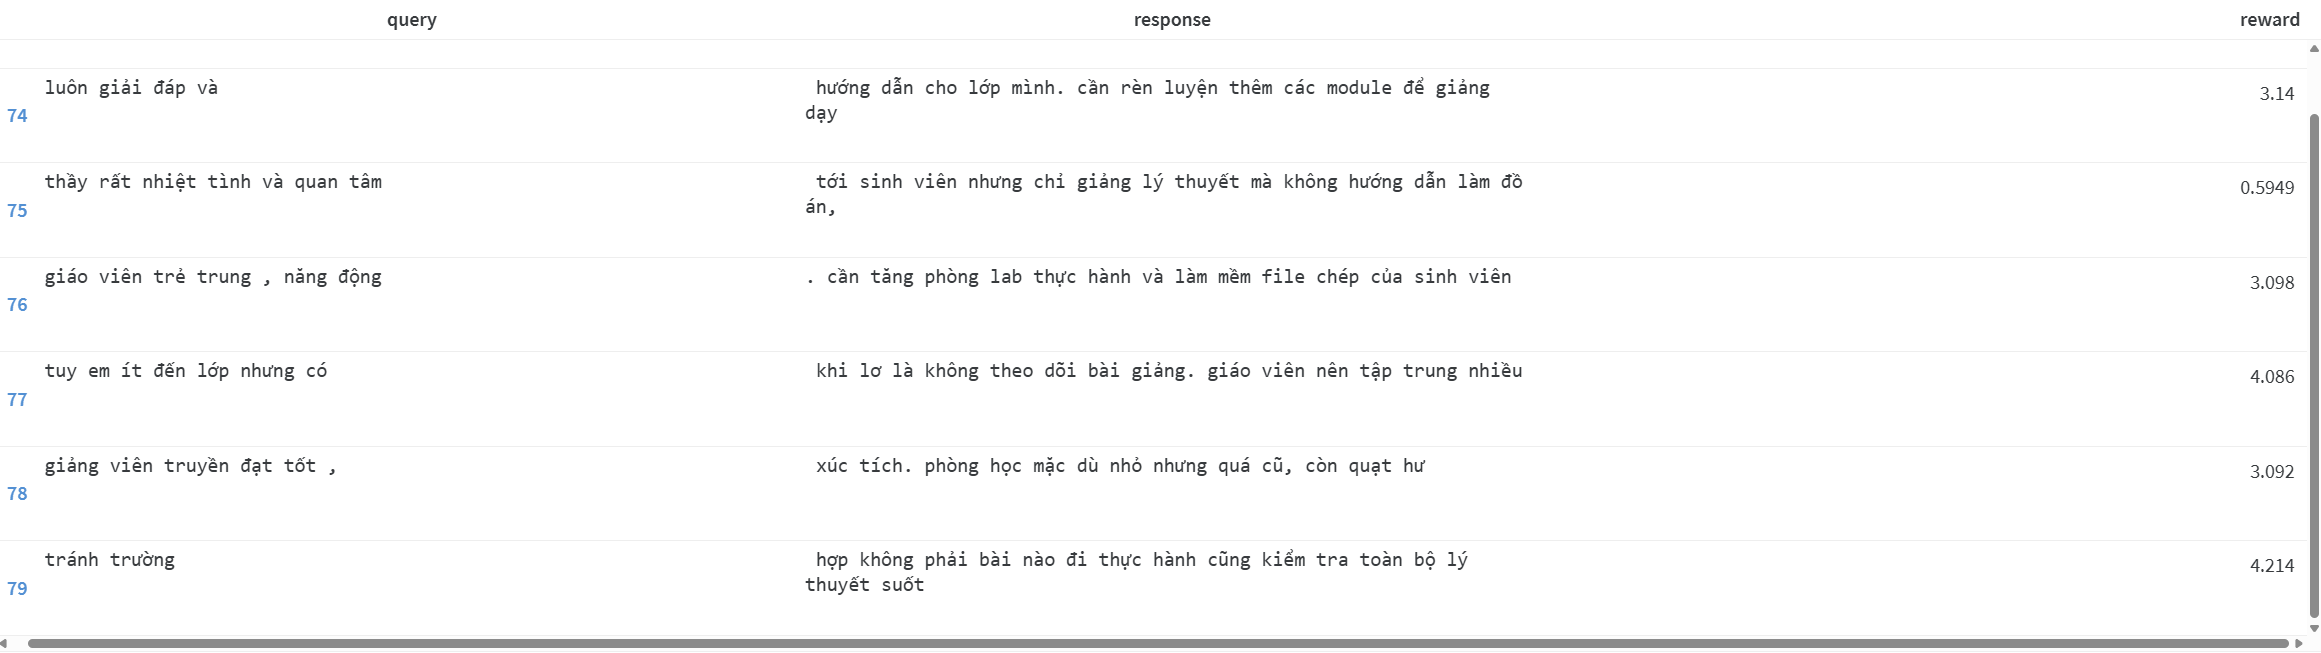


<p align="center">
 Fig 1: Some samples while training.
</p>

-------

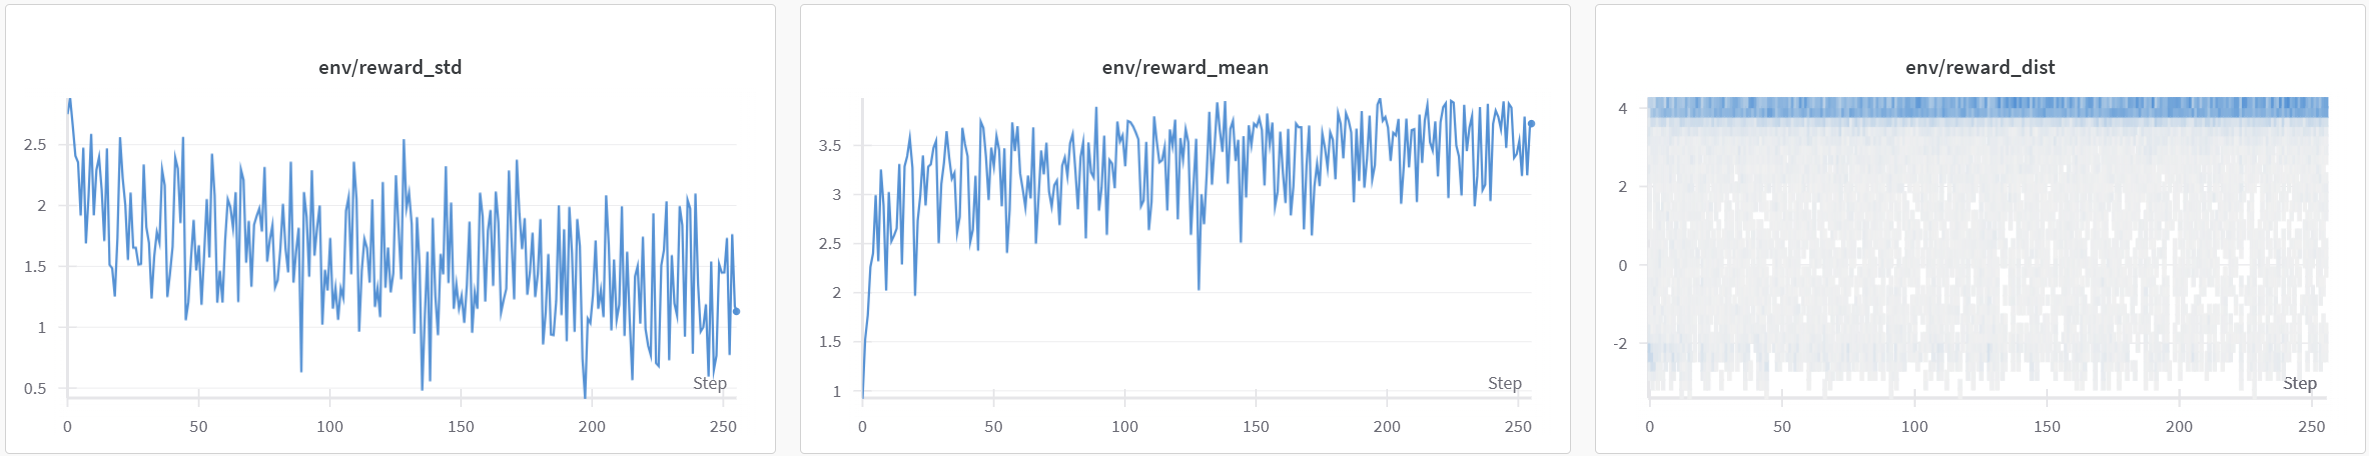

<p align="center">
 Fig 2: Reward function status.
</p>



## Before and After PPO


In [65]:
#### get a batch from the dataset
bs = 8
game_data = dict()
dataset.set_format("pandas")
df_batch = dataset[:].sample(bs)
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

feedback_tensors_ref, feedback_tensors = [], []

#### get feedback from gpt2 and gpt2_ref
for i in range(bs):
    query = torch.tensor(query_tensors[i]).to(device)

    gen_len = output_length_sampler()
    query_feedback = ref_model.generate(
        query.unsqueeze(0), max_new_tokens=gen_len, **gen_kwargs
    ).squeeze()
    feedback_len = len(query_feedback) - len(query)
    feedback_tensors_ref.append(query_feedback[-feedback_len:])

    query_feedback = model.generate(
        query.unsqueeze(0), max_new_tokens=gen_len, **gen_kwargs
    ).squeeze()
    feedback_len = len(query_feedback) - len(query)
    feedback_tensors.append(query_feedback[-feedback_len:])

#### decode feedbacks
game_data["feedback (before)"] = [
    tokenizer.decode(feedback_tensors_ref[i]) for i in range(bs)
]
game_data["feedback (after)"] = [
    tokenizer.decode(feedback_tensors[i]) for i in range(bs)
]

#### sentiment analysis of query/feedback pairs before/after
texts = [q + r for q, r in zip(game_data["query"], game_data["feedback (before)"])]
pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
positive_scores = [
    item["score"]
    for output in pipe_outputs
    for item in output
    if item["label"] == "negative"
]
game_data["rewards (before)"] = positive_scores

texts = [q + r for q, r in zip(game_data["query"], game_data["feedback (after)"])]
pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
positive_scores = [
    item["score"]
    for output in pipe_outputs
    for item in output
    if item["label"] == "negative"
]
game_data["rewards (after)"] = positive_scores

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

,query,feedback (before),feedback (after),rewards (before),rewards (after)
0,cô rất nhiệt tình,", vui tính, mong từ thầy ra các bạn bắt chước....",nhưng giờ rảnh lại chỉ mong qua bài thì chưa ...,1.469637,4.012047
1,em xin góp ý kiến như thế,"này: ""mong hai cô sẽ gửi ý kiến phản hồi của ...","này, mong nhà trường chỉnh sửa lại, cho dạy t...",3.714084,4.158318
2,"thầy dạy hay , vui nhiều phần",nghe lý thuyết rất hay! thầy hài hước vui tín...,nghe còn bị câu hỏi lỗi nhỏ thì không rõ hắn ...,-2.074794,3.635764
3,có những cái cô dạy,hay mà chấm bài dài quá! chúng em cần biết nh...,hơi khó hiểu. thực tế là thầy nên để lớp của ...,3.614214,4.205528
4,"như vậy , sinh viên làm đồ",án cũng cần có giảng viên hướng dẫn nên áp dụ...,án thì muốn làm gì thì làm. không hỗ trợ sinh...,4.115233,4.079134
5,thầy rất nhiệt,"tình, giảng lại bài rất chi tiết. thầy có khá...",tình! bài giảng chưa hiệu quả. chưa cải thiện...,-1.939914,4.109962
6,chuẩn bị bài giảng hoặc,kiểm tra lại cho phần thi hoàn chỉnh của sinh...,chat dài hơi hơn trên toast nên làm bài tập v...,3.892115,4.119471
7,học được nhiều,"về excel cả, thầy nhiệt tình, truyền đạt kinh...",từ vựng tiếng anh hơn. không cho bài tập và k...,-1.866759,4.170439


In [69]:
df_results["query"][5] + df_results["feedback (before)"][5]

'thầy rất nhiệt tình, giảng lại bài rất chi tiết. thầy có khá nhiều kiến thức về môn học. thầy đọc rất kĩ'

In [70]:
df_results["query"][5] + df_results["feedback (after)"][5]

'thầy rất nhiệt tình! bài giảng chưa hiệu quả. chưa cải thiện được khả năng giảng dạy kỹ càng. giảng viên đưa'

Reward mean/median of the generated sequences

In [71]:
print("mean:")
display(df_results[["rewards (before)", "rewards (after)"]].mean())
print()
print("median:")
display(df_results[["rewards (before)", "rewards (after)"]].median())

mean:


rewards (before)    1.365477
rewards (after)     4.061333
dtype: float64


median:


rewards (before)    2.541926
rewards (after)     4.114716
dtype: float64

In [72]:
model.save_pretrained("gpt2-vietnamese-students-negative-feedback", push_to_hub=True)
tokenizer.save_pretrained("gpt2-vietnamese-students-negative-feedback", push_to_hub=True)

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


('gpt2-vietnamese-students-negative-feedback\\tokenizer_config.json',
 'gpt2-vietnamese-students-negative-feedback\\special_tokens_map.json',
 'gpt2-vietnamese-students-negative-feedback\\vocab.json',
 'gpt2-vietnamese-students-negative-feedback\\merges.txt',
 'gpt2-vietnamese-students-negative-feedback\\added_tokens.json',
 'gpt2-vietnamese-students-negative-feedback\\tokenizer.json')